In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from keras.utils import np_utils

# Creating the dataset.

In [ ]:
!pip install pydub

/bin/sh: line 1: pip: command not found


In [ ]:
read_config = tfds.ReadConfig(try_autocache=False)
data_ds = tfds.load(
    name='speech_commands',
    read_config=read_config
)

In [ ]:
def get_processed_ds(ds, num_examples, max_len=16000, num_classes=12):
  """Get the processed dataset."""
  i = 0
  x = np.zeros([num_examples, max_len], dtype=np.float32)
  y = np.zeros([num_examples, 1], dtype=np.uint8)

  for i, example in enumerate(tfds.as_numpy(ds)):
    audio_clip = example['audio']
    label = example['label']

    # Trim and pad the audio clips to the maximum length.
    audio_clip = audio_clip[:max_len]
    audio_clip = np.pad(audio_clip, (0, max_len - audio_clip.shape[0]))
    audio_clip = np.reshape(audio_clip, (max_len)).astype(np.float32)
    
    x[i] = audio_clip
    y[i] = label
    
    # i = i + 1
    if i + 1 >= num_examples:
      break

  # STFT to extract the fourier transform on sliding windows of the input.
  # Apply STFT on the audio data, but keep only the magnitude.
  x = tf.abs(tf.signal.stft(x, frame_length=256, frame_step=128))

  # Convert the labels to a one-hot vector.
  y = np_utils.to_categorical(y, num_classes)
  return x, y

In [ ]:
x_train, y_train = get_processed_ds(data_ds['train'], 16000)
x_test, y_test = get_processed_ds(data_ds['test'], 4890)

In [ ]:
print(x_train.shape, y_train.shape)

(16000, 124, 129) (16000, 12)


In [ ]:
print(x_test.shape, y_test.shape)

(4890, 124, 129) (4890, 12)


In [ ]:
input_shape = tuple(x_train.shape.as_list()[1:])
print(input_shape)

(124, 129)


# Setting up the model training.

In [ ]:
import os

# Now let us create a callback for saving the best checkpoint so far.
# It tries to find the checkpoint with the maximum categorical accuracy.
# We will provide this to the model.fit function.

CHECKPOINTS_DIR='checkpoints'

# Create a directory for the checkpoints.
!mkdir -p $CHECKPOINTS_DIR

def best_checkpoint_callback(model_name):
  checkpoint_dir_path = os.path.join(CHECKPOINTS_DIR, model_name)
  if not os.path.exists(checkpoint_dir_path):
    os.mkdir(checkpoint_dir_path)
  checkpoint_path = os.path.join(checkpoint_dir_path, model_name)
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)


def load_best_checkpoint(model, model_name):
  checkpoint_dir_path = os.path.join(CHECKPOINTS_DIR, model_name)
  checkpoint_path = os.path.join(checkpoint_dir_path, model_name)
  model.load_weights(checkpoint_path)
  return model

In [ ]:
def base_model(
    num_classes=12,        # Number of classes in the model. 
    width_multiplier=1.0,  # Factor for scaling the network size.
    params={},             # Additional hyper-params.
):
  # Use the width_multiplier for scaling the network, the larger the value,
  # the larger the network. Keep a bound on the width though.
  w = min(max(width_multiplier, 0.05), 3.0)

  # inputs = keras.Input(shape=(16000,1))
  inputs = keras.Input(shape=input_shape)
  x = inputs

  # Create a regularizer to be used.
  reg = keras.regularizers.l2(params.get('l2_reg_weight', 2e-4))

  # Find the dropout rate for helping with further regularization.
  dropout_rate = params.get('dropout_rate', 1.0)

  # We will keep the first 'block' of layers scale invariant.
  x = layers.Conv1D(
      32, (9), padding='same', activation='relu', kernel_regularizer=reg)(
          x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv1D(
      32, (9), padding='same', activation='relu', kernel_regularizer=reg)(
          x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling1D(pool_size=(4))(x)
  x = layers.Dropout(dropout_rate)(x)

  # A short hand for the round method.
  r = lambda v: round(v)

  # We will start to scale layers from here on.
  x = layers.Conv1D(
      # Note that the number of filters grows / shrinks with `w`.
      r(64 * w), 
      (9), 
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv1D(
      r(64 * w), 
      (9),
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling1D(pool_size=(4))(x)
  x = layers.Dropout(dropout_rate)(x)

  x = layers.Conv1D(
      r(128 * w), 
      (9),
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv1D(
      r(128 * w), 
      (9),
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling1D(pool_size=(4))(x)
  x = layers.Dropout(dropout_rate)(x)

  x = layers.Flatten()(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(r(512 * w), activation='relu', kernel_regularizer=reg)(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(num_classes, kernel_regularizer=reg)(x)
  logits = x
  probabilities = layers.Activation('softmax')(logits)
  outputs = probabilities

  return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
def get_compiled_model(
    width_multiplier,
    num_classes=12,
    params={}):
  """Helper method to create the compiled model."""  
  learning_rate = params.get('learning_rate', 1e-3)

  model = base_model(
      num_classes, width_multiplier=width_multiplier, params=params)

  opt = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=opt, 
                metrics='categorical_accuracy')
  return model

In [ ]:
def get_model_name(width_multiplier, distillation=False):
  """A helper method to create a unique identifier for a model."""
  return 'wm_{}{}'.format(
      str(width_multiplier).replace('.', ''),
      ('_dist' if distillation else '')
  )

def train_model(width_multiplier, params={}, batch_size=128, epochs=100):
  """Train a solo model."""
  model_name = get_model_name(width_multiplier, distillation=False)

  model = get_compiled_model(
      width_multiplier=width_multiplier,
      params=params)
  model.summary()

  model_history = model.fit(
      x_train, 
      y_train, 
      batch_size=batch_size, 
      epochs=epochs, 
      validation_data=(x_test, y_test),
      callbacks=[best_checkpoint_callback(model_name)],
      shuffle=True)

  return model, model_history.history

# Training models solo.

## Train a large model with `width_multiplier`=1.0.

In [ ]:
width_multiplier = 1.0
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.5,
}
model_wm_10, _ = train_model(
    width_multiplier, params, epochs=50)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 124, 129)]        0         
                                                                 
 conv1d_18 (Conv1D)          (None, 124, 32)           37184     
                                                                 
 batch_normalization_18 (Bat  (None, 124, 32)          128       
 chNormalization)                                                
                                                                 
 conv1d_19 (Conv1D)          (None, 124, 32)           9248      
                                                                 
 batch_normalization_19 (Bat  (None, 124, 32)          128       
 chNormalization)                                                
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 31, 32)           0   

In [ ]:
# Create a new Model object from the previously trained model with just the 
# logits layer. We will copy it's weights from the best checkpoint so far.
# This model will be used as the teacher, to extract the logits.
model_wm_10_without_softmax = tf.keras.Model(
    inputs=model_wm_10.inputs,
    outputs=model_wm_10.layers[-2].output)
model_wm_10_without_softmax.compile(metrics='categorical_accuracy')

In [ ]:
# Load the weights and evaluate the model.
# Even though the previous Model object's output was probabilities, and this new
# model's output are the logits, it is essentially the same because the logits
# will retain the same order as the probabilities. Thus, for the accuracy metric
# they are identical.
model_wm_10_without_softmax = load_best_checkpoint(
    model_wm_10_without_softmax, 
    get_model_name(1.0))
model_wm_10_without_softmax.evaluate(x_test, y_test)

153/153 [==============================] - 1s 2ms/step - loss: 0.1395 - categorical_accuracy: 0.8881


[0.13952623307704926, 0.8881390690803528]

## Train a smaller model with `width_multiplier`=0.1

In [ ]:
# Now let's train a solo model, with width_multiplier=0.1.
width_multiplier = 0.1
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.2,
}
model_wm_01, model_wm_01_history = train_model(width_multiplier, params, 
                                               epochs=50)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 124, 129)]        0         
                                                                 
 conv1d_24 (Conv1D)          (None, 124, 32)           37184     
                                                                 
 batch_normalization_24 (Bat  (None, 124, 32)          128       
 chNormalization)                                                
                                                                 
 conv1d_25 (Conv1D)          (None, 124, 32)           9248      
                                                                 
 batch_normalization_25 (Bat  (None, 124, 32)          128       
 chNormalization)                                                
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 31, 32)           0   

In [ ]:
# Let us find the best checkpoint and compute its accuracy.
model_wm_01 = load_best_checkpoint(model_wm_01, get_model_name(0.1))
model_wm_01.evaluate(x_test, y_test)

153/153 [==============================] - 0s 2ms/step - loss: 1.0097 - categorical_accuracy: 0.7166


[1.0096887350082397, 0.716564416885376]

# Setting up distillation training.

### Establishing our teacher model.

In [ ]:
teacher_model = model_wm_10_without_softmax

In [ ]:
# Create the distillation labels by stacking the teacher model's outputs 
# and the ground-truth one-hot labels together.
def get_distillation_labels(teacher_model_instance, x_ds, y_ds):
  """Add the teacher logits to the label tensor."""
  # Generate the teacher model's logits.
  teacher_logits = teacher_model_instance.predict(x_ds)
  # Create the stacked tensor.
  y_dist_ds = tf.stack([y_ds, teacher_logits], axis=1)
  return y_dist_ds

In [ ]:
y_dist_train = get_distillation_labels(teacher_model, x_train, y_train)
y_dist_test = get_distillation_labels(teacher_model, x_test, y_test)

In [ ]:
def get_compiled_distillation_model(
    width_multiplier=1.0,
    num_classes=12,
    params={}):
  learning_rate = params.get('learning_rate', 1e-3)
  temperature = params.get('temperature', 1.0)
  distillation_weight = params.get('distillation_weight', 1.0)

  model = base_model(
      num_classes, width_multiplier=width_multiplier, params=params)

  def distillation_loss_fn(y_true_combined, y_pred):
    """Custom distillation loss function."""
    # We will split the y tensor to extract the ground-truth and the teacher's
    # soft-labels.
    y_true_split = tf.split(y_true_combined, 2, axis=1)
    
    # Create the ground-truth loss function as usual.
    ground_truth = tf.squeeze(y_true_split[0], axis=1)
    gt_loss = tf.keras.losses.CategoricalCrossentropy()(
      ground_truth, y_pred)
    
    # Create the distillation loss using the soft-labels.
    logits = tf.squeeze(y_true_split[1], axis=1)
    soft_labels = tf.nn.softmax(logits / temperature)
    dist_loss = tf.keras.losses.CategoricalCrossentropy()(
        soft_labels, y_pred)

    # Combine the two into a single loss function.
    loss = gt_loss + distillation_weight * dist_loss * (temperature ** 2.0)
    return loss
  
  def categorical_accuracy(labels, model_pred):
    # Extract the ground-truth labels.
    ground_truth = tf.split(labels, 2, axis=1)[0]
    ground_truth = tf.squeeze(ground_truth, axis=1)

    # Compute the accuracy as usual.
    return tf.keras.metrics.categorical_accuracy(ground_truth, model_pred)

  opt = keras.optimizers.Adam(learning_rate=learning_rate)

  # Compile the model with the custom loss function and metric.
  model.compile(
      loss=distillation_loss_fn,
      metrics=[categorical_accuracy],
      optimizer=opt)
  return model

def train_dist_model(width_multiplier, params={}, batch_size=128, epochs=100):
  model_name = get_model_name(width_multiplier, distillation=True)

  model = get_compiled_distillation_model(
      width_multiplier=width_multiplier,
      params=params)
  model.summary()

  # The change here would be that we are using the distillation labels.
  model_history = model.fit(
      x_train, 
      y_dist_train, 
      batch_size=batch_size, 
      epochs=epochs, 
      validation_data=(x_test, y_dist_test),
      callbacks=[best_checkpoint_callback(model_name)],
      shuffle=True)

  return model, model_history.history

# Train the `width_multiplier`=0.1 model with distillation.

In [ ]:
# Train a model with width_multiplier=0.1 in a distillation setting.
width_multiplier = 0.1
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.2,
    'distillation_weight': 1.0,
}
model_wm_01_dist, model_wm_01_dist_history = train_dist_model(
    width_multiplier, params, epochs=50)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 124, 129)]        0         
                                                                 
 conv1d_30 (Conv1D)          (None, 124, 32)           37184     
                                                                 
 batch_normalization_30 (Bat  (None, 124, 32)          128       
 chNormalization)                                                
                                                                 
 conv1d_31 (Conv1D)          (None, 124, 32)           9248      
                                                                 
 batch_normalization_31 (Bat  (None, 124, 32)          128       
 chNormalization)                                                
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 31, 32)           0   

In [ ]:
model_wm_01_dist = load_best_checkpoint(
    model_wm_01_dist, 
    get_model_name(0.1, distillation=True))
model_wm_01_dist.evaluate(x_test, y_dist_test)

153/153 [==============================] - 0s 3ms/step - loss: 1.3072 - categorical_accuracy: 0.8063


[1.3071538209915161, 0.80633944272995]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

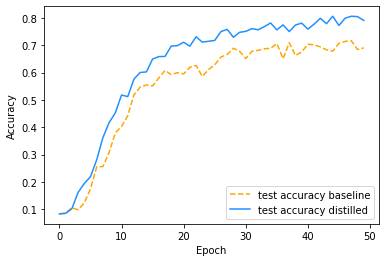

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(model_wm_01_history['val_categorical_accuracy'],
         label='test accuracy baseline',
         c='orange',ls='--')

plt.plot(model_wm_01_dist_history['val_categorical_accuracy'],
         label='test accuracy distilled',
         c='dodgerblue', ls='-')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()